In [ ]:
!pip install numpy scikit-learn compress-fasttext xmltodict matplotlib

In [109]:
from importlib import reload

import ruwordnet.synsets
import ruwordnet.ruwordnet

reload(ruwordnet.synsets)
reload(ruwordnet.ruwordnet)

from ruwordnet.ruwordnet import RuWordNet

In [1]:
from ruwordnet import RuWordNet
wn = RuWordNet()
wn.load_from_xml(root='data')

# Using the thesaurus

In [22]:
for sense in wn.get_senses('замок'):
    print(sense.synset)

Synset(id="126228-N", title="СРЕДНЕВЕКОВЫЙ ЗАМОК")
Synset(id="114707-N", title="ЗАМОК ДЛЯ ЗАПИРАНИЯ")


In [28]:
wn.get_senses('замок')[0].synset.hypernyms

[Synset(id="113935-N", title="ДВОРЕЦ"),
 Synset(id="124420-N", title="КРЕПОСТЬ (ОБОРОНИТЕЛЬНОЕ СООРУЖЕНИЕ)")]

In [12]:
wn.get_senses('спаржа')[0].synset.hypernyms

[Synset(id="348-N", title="ОВОЩИ"),
 Synset(id="4789-N", title="ТРАВЯНИСТОЕ РАСТЕНИЕ"),
 Synset(id="6878-N", title="ОВОЩНАЯ КУЛЬТУРА")]

In [94]:
wn.get_senses('авокадо')

[Sense(id="153966-N-124560", name="АВОКАДО"),
 Sense(id="144242-N-124560", name="АВОКАДО"),
 Sense(id="144305-N-124560", name="АВОКАДО")]

In [130]:
veg = wn.get_senses('спаржа')[0].synset.hypernyms[0]
veg

Synset(id="348-N", title="ОВОЩИ")

In [131]:
veg.hyponyms

[Synset(id="107993-N", title="АРТИШОК"),
 Synset(id="108482-N", title="СПАРЖА"),
 Synset(id="118660-N", title="ЗЕЛЕНЫЙ ГОРОШЕК"),
 Synset(id="144181-N", title="БАКЛАЖАН (ПЛОД)"),
 Synset(id="144182-N", title="ЛУК (РАСТЕНИЕ)"),
 Synset(id="144183-N", title="ЧЕСНОК"),
 Synset(id="144184-N", title="ОГУРЕЦ (ПЛОД)"),
 Synset(id="144191-N", title="ПОМИДОР (ПЛОД)"),
 Synset(id="144194-N", title="ТЫКВА (ПЛОД)"),
 Synset(id="144207-N", title="СТРУЧКОВЫЙ ПЕРЕЦ (ПЛОД)"),
 Synset(id="144216-N", title="КАБАЧОК (ПЛОД)"),
 Synset(id="144232-N", title="КОЧАН КАПУСТЫ"),
 Synset(id="148896-N", title="КОРНЕПЛОДНЫЕ ОВОЩИ"),
 Synset(id="153883-N", title="ЗЕЛЕНЬ (ОВОЩИ)")]

In [132]:
wn.get_senses('продукт')[0].synset.hyponyms[0].hyponyms[1].hyponyms[0].sense

[Sense(id="134270-N-189833", name="НЕСУЩАЯ СТЕНА"),
 Sense(id="134270-N-745751", name="КАПИТАЛЬНАЯ СТЕНА")]

# Predicting hypernyms

In [4]:
import numpy as np
import compress_fasttext

from collections import Counter
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_100.bin'
)

In [6]:
def vectorize(text):
    vec = np.mean([ft[word] for word in text.lower().split() if len(word) >= 3], axis=0)
    vec /= sum(vec**2) ** 0.5 
    return vec

def distance2vote(d, a=3, b=5):
    sim = np.maximum(0, 1 - d**2/2)
    return np.exp(-d**a) * sim **b

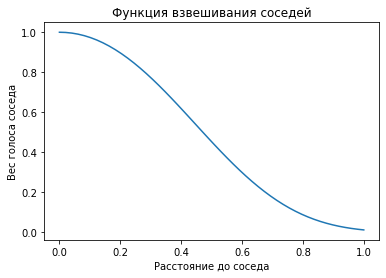

In [7]:
x = np.linspace(0, 1)
plt.plot(x, distance2vote(x))
plt.xlabel('Расстояние до соседа')
plt.ylabel('Вес голоса соседа')
plt.title('Функция взвешивания соседей');

In [8]:
words, vectors, synset_ids = [], [], []
for synset in wn.synsets:
    if synset.part_of_speech != 'V':
        continue
    for sense in synset.sense:
        words.append(sense.name)
        vectors.append(vectorize(sense.name))
        synset_ids.append(synset.id)
vectors = np.stack(vectors)
tree = KDTree(vectors)

In [9]:
votes = Counter()
dists, ids = tree.query(vectorize('кудахтать').reshape(1, -1), k=100)
for idx, distance in zip(ids[0], dists[0]):
    for hyper in wn[synset_ids[idx]].hypernyms:
        votes[hyper.id] += distance2vote(distance)
    print(words[idx], [t.title for t in wn[synset_ids[idx]].hypernyms])

БАРАХТАТЬСЯ ['ДВИЖЕНИЕ, ПЕРЕМЕЩЕНИЕ', 'ПЛЕСКАТЬСЯ В ВОДЕ']
ГОГОТАТЬ ['СМЕЯТЬСЯ (ИЗДАВАТЬ СМЕХ)', 'РАЗРАЗИТЬСЯ (БУРНО ВЫРАЗИТЬ)']
ГУКАТЬ ['ПРОИЗНЕСТИ, ВЫГОВОРИТЬ, ПРОГОВОРИТЬ']
ЮРКАТЬ ['СПРЯТАТЬСЯ В УКРЫТИЕ']
ТАРАХТЕТЬ ['ПРОИЗНЕСТИ, ВЫГОВОРИТЬ, ПРОГОВОРИТЬ', 'БОЛТАТЬ, ЧЕСАТЬ ЯЗЫКОМ']
ШМЫГАТЬ ['ДВИЖЕНИЕ, ПЕРЕМЕЩЕНИЕ']
ШМЫГАТЬ ['МЕЛЬКАТЬ ПЕРЕД ГЛАЗАМИ', 'ПРОЙТИ МИМО']
ПОНУКАТЬ ['СКЛОНИТЬ, ПОБУДИТЬ']
ХНЫКАТЬ ['ЖАЛОВАТЬСЯ (ВЫСКАЗЫВАТЬ НЕУДОВОЛЬСТВИЕ)', 'НАДОЕСТЬ']
ПОВИЗГИВАТЬ ['ИЗДАТЬ ЗВУК']
ГАВКАТЬ ['ИЗДАТЬ ЗВУК']
ФЫРКАТЬ ['ПРОИЗНЕСТИ, ВЫГОВОРИТЬ, ПРОГОВОРИТЬ', 'ВОРЧАТЬ (БОРМОТАТЬ)']
ФЫРЧАТЬ ['ПРОИЗНЕСТИ, ВЫГОВОРИТЬ, ПРОГОВОРИТЬ', 'ВОРЧАТЬ (БОРМОТАТЬ)']
УРЧАТЬ ['ИЗДАТЬ ЗВУК']
НАУСЬКИВАТЬ ['НАПАСТЬ, СОВЕРШИТЬ НАПАДЕНИЕ', 'ПРЕСЛЕДОВАТЬ, ГНАТЬСЯ']
НАУСЬКИВАТЬ ['ПОДСТРЕКАТЬ, ПРОВОЦИРОВАТЬ', 'ПОРТИТЬ ОТНОШЕНИЯ']
СВИХИВАТЬСЯ ['ЗАБОЛЕТЬ БОЛЕЗНЬЮ']
ДОКРИКИВАТЬСЯ ['ДОЗВАТЬСЯ']
ДОКРИКИВАТЬСЯ ['ДОВЕСТИ СЕБЯ', 'НАВРЕДИТЬ СЕБЕ']
ЖАЛОБНО ВЫТЬ ['ВЫТЬ', 'ВИЗЖАТЬ']
МЕТАТЬСЯ КАК УГОРЕЛЫЙ ['БЕЖАТЬ (ДВИГАТЬСЯ

In [10]:
for sid, score in votes.most_common(10):
    print(score,  wn[sid].title)

0.6925543543920146 ИЗДАТЬ ЗВУК
0.4306341411813687 ПРОИЗНЕСТИ, ВЫГОВОРИТЬ, ПРОГОВОРИТЬ
0.29578542267095376 ДВИЖЕНИЕ, ПЕРЕМЕЩЕНИЕ
0.21784698084743057 СМЕЯТЬСЯ (ИЗДАВАТЬ СМЕХ)
0.19409141918335493 ПЛЕСКАТЬСЯ В ВОДЕ
0.1325509436427577 РАЗРАЗИТЬСЯ (БУРНО ВЫРАЗИТЬ)
0.11629879019881803 БОЛТАТЬ, ЧЕСАТЬ ЯЗЫКОМ
0.11420901282482374 УДАРИТЬ, НАНЕСТИ УДАР
0.11343697413233847 ШЕВЕЛИТЬ ЧАСТЬЮ ТЕЛА
0.11267866978103516 КРИЧАТЬ, ИЗДАВАТЬ КРИК


# Найди лишнее 
ДИВАН, ШКАФ, ЛАМПА, СТОЛ

In [121]:
import math


def get_all_hypernyms(wn, word, max_level=100):
    """ Return dict of all hypernyms of a word and their distances """
    front = [sense.synset for sense in wn.get_senses(word)]
    levels = {}
    for level in range(max_level):
        if not front:
            break
        new_front = []
        for synset in front:
            if synset.id not in levels:
                levels[synset.id] = level
                new_front.extend(synset.hypernyms)
        front = new_front
    return levels

def get_closest_common(levels1, levels2):
    """ Find the closest common hypernym and sum of distances to it"""
    result = None
    result_distance = math.inf
    for id, distance in levels1.items():
        if id in levels2:
            total = distance + levels2[id]
            if total < result_distance:
                result_distance = total
                result = id
    return result, result_distance

In [134]:
words = ['ДИВАН', 'ШКАФ', 'ЛАМПА', 'СТОЛ']
print('\t\t', '\t'.join(words))
for w1 in words:
    print(w1, end='\t')
    for w2 in words:
        n, d = get_closest_common(get_hypernyms(wn, w1), get_hypernyms(wn, w2))
        print(d, end='\t\t')
    print()

		 ДИВАН	ШКАФ	ЛАМПА	СТОЛ
ДИВАН	0		3		10		3		
ШКАФ	3		0		5		2		
ЛАМПА	10		5		0		7		
СТОЛ	3		2		7		0		


In [130]:
name, distance = get_closest_common(get_hypernyms(wn, 'лампа'), get_hypernyms(wn, 'шкаф'))
print(distance, name, wn[name].title)

5 106555-N ТЕХНИЧЕСКОЕ УСТРОЙСТВО


In [102]:
for k, v in get_hypernyms(wn, 'лампа').items():
    print(k, v, wn[k])

128561-N 0 Synset(id="128561-N", title="ОСВЕТИТЕЛЬНЫЙ ПРИБОР")
8785-N 0 Synset(id="8785-N", title="ЭЛЕКТРИЧЕСКАЯ ЛАМПА")
4222-N 1 Synset(id="4222-N", title="СВЕТОТЕХНИЧЕСКОЕ ОБОРУДОВАНИЕ")
107646-N 1 Synset(id="107646-N", title="ИСТОЧНИК ОСВЕЩЕНИЯ")
2070-N 2 Synset(id="2070-N", title="ЭЛЕКТРОТЕХНИЧЕСКОЕ ОБОРУДОВАНИЕ")
106488-N 2 Synset(id="106488-N", title="ИСХОДНЫЙ ПУНКТ")
149201-N 3 Synset(id="149201-N", title="ИНЖЕНЕРНОЕ ОБОРУДОВАНИЕ")
106613-N 3 Synset(id="106613-N", title="РОЛЬ, ПОЛОЖЕНИЕ, МЕСТО")
1320-N 4 Synset(id="1320-N", title="ОБОРУДОВАНИЕ")
106555-N 4 Synset(id="106555-N", title="ТЕХНИЧЕСКОЕ УСТРОЙСТВО")
106553-N 5 Synset(id="106553-N", title="ПРИСПОСОБЛЕНИЕ, ИНСТРУМЕНТ")
106554-N 6 Synset(id="106554-N", title="ПРЕДМЕТ, ВЕЩЬ")
147133-N 7 Synset(id="147133-N", title="ФИЗИЧЕСКИЙ ОБЪЕКТ")
147134-N 8 Synset(id="147134-N", title="ФИЗИЧЕСКАЯ СУЩНОСТЬ")
153782-N 9 Synset(id="153782-N", title="ПОСТОЯННАЯ СУЩНОСТЬ")


In [131]:
wn["149201-N"].hypernyms

[Synset(id="1320-N", title="ОБОРУДОВАНИЕ"),
 Synset(id="106555-N", title="ТЕХНИЧЕСКОЕ УСТРОЙСТВО")]

In [132]:
for k, v in get_hypernyms(wn, 'стол').items():
    print(k, v, wn[k])

107294-N 0 Synset(id="107294-N", title="СТОЛ")
146834-N 0 Synset(id="146834-N", title="СТОЛ ДЛЯ ЕДЫ")
1253-N 1 Synset(id="1253-N", title="МЕБЕЛЬ")
106554-N 1 Synset(id="106554-N", title="ПРЕДМЕТ, ВЕЩЬ")
9059-N 2 Synset(id="9059-N", title="ПРОДУКЦИЯ ДЕРЕВООБРАБОТКИ")
130019-N 2 Synset(id="130019-N", title="НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ")
146828-N 2 Synset(id="146828-N", title="ПРЕДМЕТ ИНТЕРЬЕРА")
147133-N 2 Synset(id="147133-N", title="ФИЗИЧЕСКИЙ ОБЪЕКТ")
106507-N 3 Synset(id="106507-N", title="ПРОДУКТ ПРОИЗВОДСТВА")
56-N 3 Synset(id="56-N", title="ПРОМЫШЛЕННАЯ ПРОДУКЦИЯ")
562-N 3 Synset(id="562-N", title="ТОВАР")
1252-N 3 Synset(id="1252-N", title="ПОТРЕБИТЕЛЬСКИЕ ТОВАРЫ")
147134-N 3 Synset(id="147134-N", title="ФИЗИЧЕСКАЯ СУЩНОСТЬ")
106505-N 4 Synset(id="106505-N", title="ПРОДУКТ ТРУДА")
153782-N 4 Synset(id="153782-N", title="ПОСТОЯННАЯ СУЩНОСТЬ")


In [59]:
synset1 = wikiwordnet.get_synsets('диван')[0]
synset2 = wikiwordnet.get_synsets('стол')[0]
wikiwordnet.get_lowest_common_hypernyms(synset1, synset2)

[(<wiki_ru_wordnet.synset.Synset at 0x5dae7f2888>, 1, 1)]

NameError: name 'ДИВАН' is not defined